In [6]:
!pip install nb_black lightgbm pyarrow umap-learn BorutaShap

In [1]:
%load_ext lab_black
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import glob
import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import umap
import lightgbm as lgb

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

In [46]:
def gather_df(
    dataset_name,
    do_extract=True,
    shift_features=True,
    shift_features_longterm=True,
    load_related_data=True,
):
    fname = "./data/kaggle-preprocessed/{}.feather".format(dataset_name)
    if not os.path.exists(fname):
        raise Exception("preprocessed file doesnt exist")
    df = pd.read_feather(fname)
    df = df.set_index(df.index_col)
    df = df.drop("index_col", axis=1).drop("Date", axis=1)

    if load_related_data:
        related_datas = []
        for col in df.columns:
            if "rain" in col:
                location = col.replace("rainfall_", "")
            elif "temperature" in col:
                location = col.replace("temperature_", "")
            else:
                continue
            filename = "./data/nasa-power/{}.feather".format(location)
            if os.path.exists(filename):
                df_related = pd.read_feather(filename)
                df_related = df_related.set_index(df_related.index_col)
                df_related = df_related.drop("index_col", axis=1)
                df_related.columns = [
                    "{}_{}".format(location, c.lower()) for c in df_related.columns
                ]

                related_datas.append(df_related)
            else:
                print("not found: {}".format(col))

        df_related = pd.concat(related_datas)
        df_related = df_related.groupby(df_related.index).max()
        df = pd.merge(df, df_related, how="left", left_index=True, right_index=True)
        for col in df.columns:
            if "_index" in col:
                df = df.drop(col, axis=1)
    for col in df.columns:
        df[col] = df[col].astype(np.float)

    ignore_cols = ["year", "month", "week", "day", " day_of_year"]

    df = df.rename(
        columns={
            "flow_rate_lupa": "target_flow_rate_lupa",
            "depth_to_groundwater_cos": "target_depth_to_groundwater_cos",
            "depth_to_groundwater_pozzo_9": "target_depth_to_groundwater_pozzo_9",
            "flow_rate_madonna_di_canneto": "target_flow_rate_madonna_di_canneto",
        }
    )

    if dataset_name == "aquifer_luco":
        df = df.rename(
            columns={
                "target_depth_to_groundwater_pozzo_1": "depth_to_groundwater_pozzo_1",
                "target_depth_to_groundwater_pozzo_3": "depth_to_groundwater_pozzo_3",
                "target_depth_to_groundwater_pozzo_4": "depth_to_groundwater_pozzo_4",
            }
        )
    for col in [
        "target_depth_to_groundwater_lt2",
        "target_depth_to_groundwater_cos",
        "target_depth_to_groundwater_sal",
        "target_flow_rate_bugnano",
        "target_flow_rate_arbure",
        "target_flow_rate_ermicciolo",
        "river_arno",
    ]:
        if col in df.columns:
            df[col] = df[col].replace(0, np.nan)

    if do_extract:
        for category in [
            "_ts",
            "ws10m",
            "ws10m_min",
            "ws10m_max",
            "ws50m",
            "ws50m_max",
            "ws50m_min",
            "prectot",
            "_ps",
            "qv2m",
            "rh2m",
            "t2m",
            "t2mwet",
            "t2m_max",
            "t2m_min",
        ]:
            cols = [c for c in df.columns if c.endswith(category)]
            new_col = df[cols].mean(axis=1).copy()
            df = df.drop(cols, axis=1)
            df[category] = new_col
        for category in ["rainfall", "temperature"]:
            cols = [c for c in df.columns if c.startswith(category)]
            new_col = df[cols].mean(axis=1)
            df = df.drop(cols, axis=1)
            df[category] = new_col

    if shift_features:
        for col in df.columns:
            if "shift" not in col:
                for i in range(1, 5):
                    df["{}_shift_{}".format(col, i)] = df[col].shift(i)
                for i in range(5, 20, 5):
                    df["{}_shift_{}".format(col, i)] = (
                        df[col].rolling(5).mean().shift(i)
                    )
    if shift_features_longterm:
        for col in tqdm.tqdm(df.columns):
            if "shift" not in col and df[col].dtype == np.float or col in ignore_cols:
                for i in range(1, 12):
                    df["{}_shift_longterm_{}".format(col, i)] = (
                        df[col].rolling(30).mean().shift(i * 30)
                    )

    return df

target_depth_to_groundwater_lt2


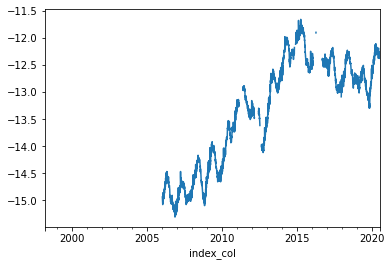

target_depth_to_groundwater_sal


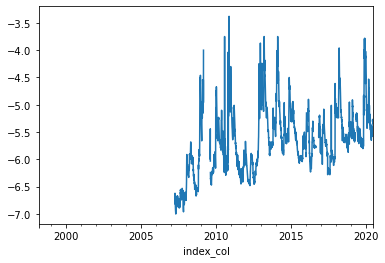

target_depth_to_groundwater_cos


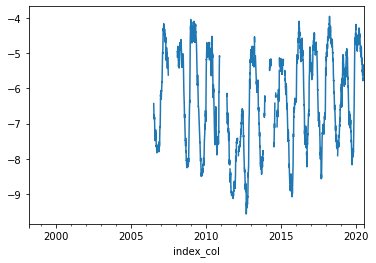

target_flow_rate_bugnano


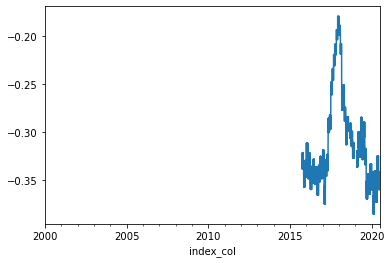

target_flow_rate_arbure


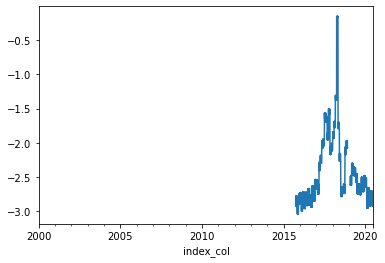

target_flow_rate_ermicciolo


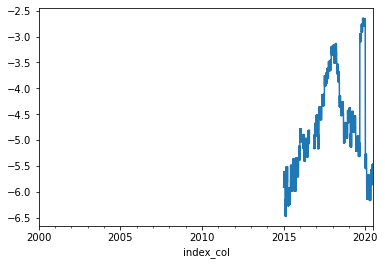

target_flow_rate_galleria_alta


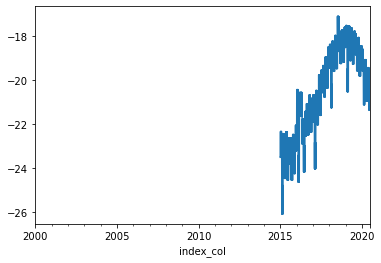

target_depth_to_groundwater_p24


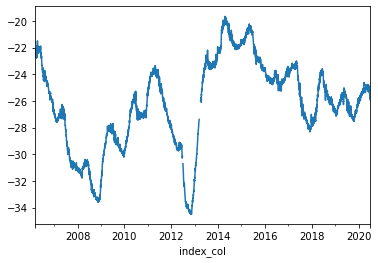

target_depth_to_groundwater_p25


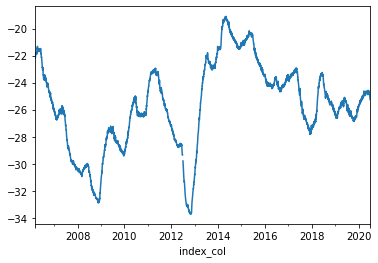

target_depth_to_groundwater_pozzo_1


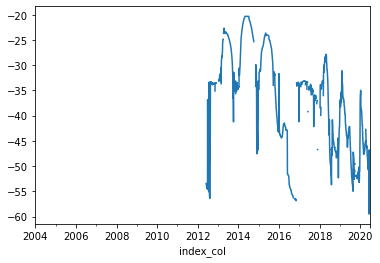

target_depth_to_groundwater_pozzo_2


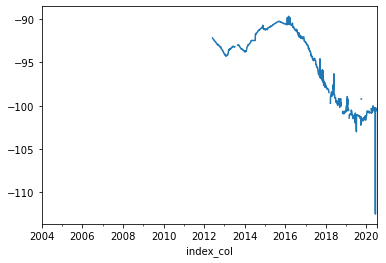

target_depth_to_groundwater_pozzo_3


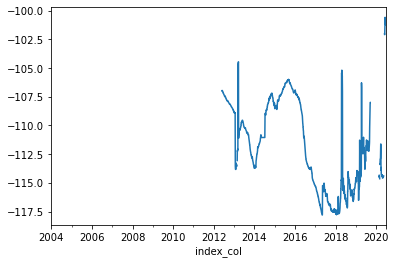

target_depth_to_groundwater_pozzo_4


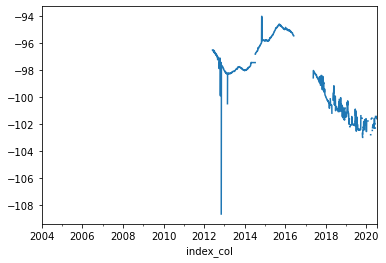

target_depth_to_groundwater_pozzo_5


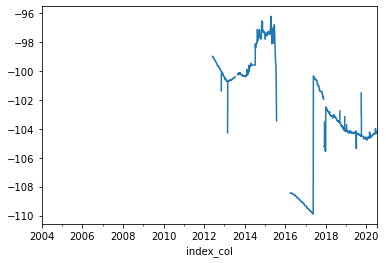

target_depth_to_groundwater_pozzo_6


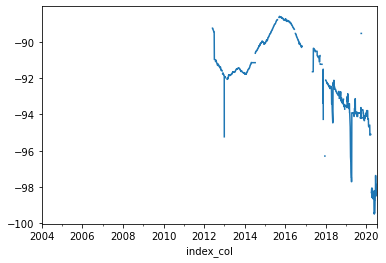

target_depth_to_groundwater_pozzo_7


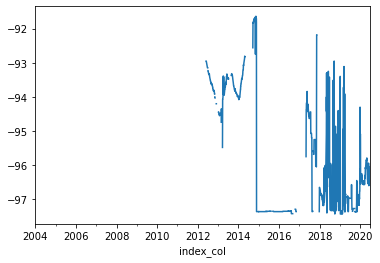

target_depth_to_groundwater_pozzo_8


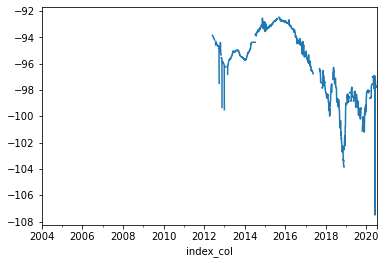

target_depth_to_groundwater_pozzo_9


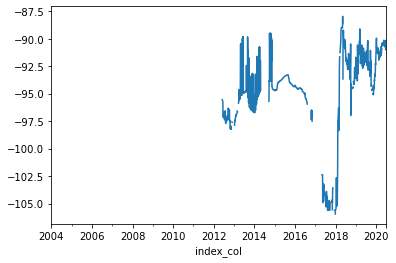

target_depth_to_groundwater_podere_casetta


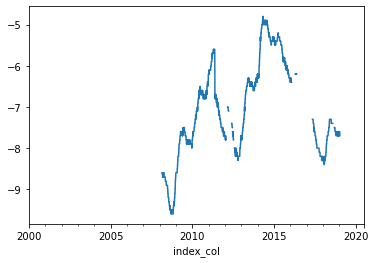

target_hydrometry_nave_di_rosano


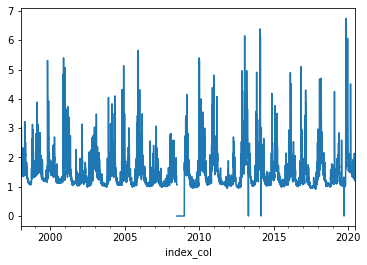

target_lake_level


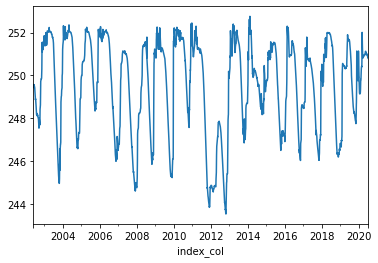

target_flow_rate


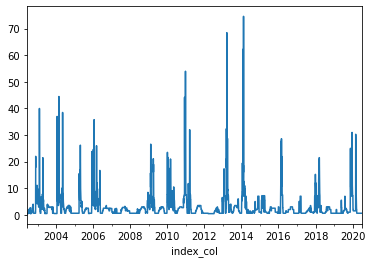

target_flow_rate_lupa


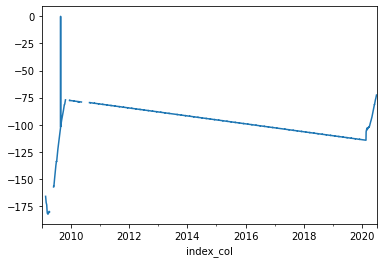

target_flow_rate_madonna_di_canneto


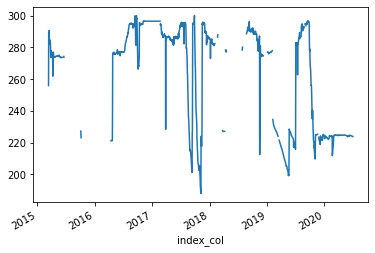

In [47]:
import matplotlib.pyplot as plt

data_sets = [
    "aquifer_auser",
    "water_spring_amiata",
    "aquifer_petrignano",
    "aquifer_doganella",
    "aquifer_luco",
    "river_arno",
    "lake_bilancino",
    "water_spring_lupa",
    "water_spring_madonna_di_canneto",
]
for dataset in data_sets:
    df = gather_df(dataset, True, False, False, True)
    for target_col in [c for c in df.columns if "target" in c]:
        print(target_col)
        df[target_col].plot()
        plt.show()

In [ ]:
results = []
data_sets = [
        "aquifer_auser",
        "water_spring_amiata",
        "aquifer_petrignano",
        "aquifer_doganella",
        "aquifer_luco",
        "river_arno",
        "lake_bilancino",
#     "water_spring_lupa",
#         "water_spring_madonna_di_canneto",
]
for dataset in data_sets:
    df = gather_df(dataset, True, False, False, True)

    for target_col in [c for c in df.columns if "target" in c]:
        for shift in [30, 60]:
            y = df[target_col].pct_change(shift).shift(-shift)

            pipeline = Pipeline(
                memory=None,
                steps=[
                    ("impute", KNNImputer()),
                    #                     ("scaling", StandardScaler(copy=True, with_mean=True, with_std=True)),
                    ("best", SelectFromModel(lgb.LGBMRegressor())),
                    #         ("dim_reduction", PCA(n_components=10)),
                    #                             ("dim_reduction", umap.UMAP(n_components=5)),
                ],
                verbose=False,
            )

            for split in range(3000, len(df.index) - 100, 100):

                X_train = df.iloc[:split]
                X_test = df.iloc[split + shift :]
                y_train = y.iloc[:split]
                y_test = y.iloc[split + shift :]

                x_filtered = ~pd.isna(y_train)

                if len(X_train[x_filtered]) < 500:
                    continue
                if len(X_test) < 10:
                    continue

                #                 X_train_piped = pipeline.fit_transform(X_train[x_filtered], y_train[x_filtered])
                #                 X_test_piped = pipeline.transform(X_test)
                y_train = y_train[x_filtered]

                rmodel = lgb.LGBMRegressor()
                rmodel.fit(X_train[x_filtered], np.clip(y_train, -1, 10))

                p = rmodel.predict(X_test)
                dfp = pd.DataFrame(
                    {
                        "p": p,
                        "y": y_test,
                        "y_orig": df[target_col].iloc[split + shift :] * y_test,
                        "p_orig": df[target_col].iloc[split + shift :] * p,
                    }
                ).iloc[:100]
                dfp = dfp[~pd.isna(dfp.y)]
                mae = np.mean(np.abs(dfp.p - dfp.y))
                rmse = np.sqrt(np.mean(dfp.p - dfp.y) ** 2)

                results.append(
                    {
                        "dataset": dataset,
                        "split": split,
                        "mae": mae,
                        "rmse": rmse,
                        "type": "all",
                        "target_col": target_col,
                        "shift": shift,
                        "mae_orig": np.mean(np.abs(dfp.p_orig - dfp.y_orig)),
                        "rmse_orig": np.sqrt(np.mean(dfp.p_orig - dfp.y_orig) ** 2),
                    }
                )
                #                 feat_model = lgb.LGBMRegressor()
                #                 feat_model.fit(X_train_piped, y_train)

                #                 p = feat_model.predict(X_test_piped)
                #                 dfp = pd.DataFrame({"p": p, "y": y_test}).iloc[:100]
                #                 mae = np.mean(np.abs(dfp.p - dfp.y))
                #                 rmse= np.sqrt(np.mean(dfp.p - dfp.y)**2)
                #                 results.append({
                #                     'dataset': dataset,
                #                     'split': split,
                #                     'mae': mae,
                #                     'rmse': rmse,
                #                     'type': 'pipeline',
                #                      'target_col': target_col,
                #                     'shift': shift
                #                 })
                pd.DataFrame(results).to_json(
                    "./simres-pct-simplefeat-capped-target.json"
                )

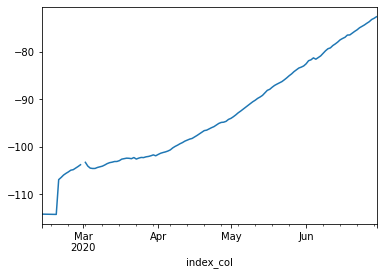

In [103]:
df[target_col].iloc[split + shift :].plot()

In [102]:
dfp

,p,y,y_orig,p_orig
index_col,,,,
2020-02-13,0.006196,-0.136690,15.61,-0.707597
2020-02-14,0.006364,-0.138692,15.84,-0.726847
2020-02-15,0.005849,-0.139993,15.99,-0.668097
2020-02-16,0.008570,-0.142782,16.31,-0.978952
2020-02-17,0.005849,-0.145571,16.63,-0.668214
...,...,...,...,...
2020-04-27,0.005771,-0.220559,20.92,-0.547372
2020-04-28,0.005567,-0.223629,21.20,-0.527763
2020-04-29,0.005785,-0.227013,21.48,-0.547411
